# Ordination

Multidimensional data are hard to picture. Our minds can easily grasp one, two, and three dimensions. But more than that, we start losing track of what’s close, what’s far, and which direction “variation” even points to. Ordination methods are ways to *flatten* those many dimensions onto a smaller space while keeping the essence of how observations relate to one another.

Here, we’ll explore three of them:

- **PCA (principal components analysis)** the most common, for structure and gradients
- **LDA (linear discriminant Aaalysis)** — for separating known groups
- **RDA (redundancy analysis)** — for linking responses to predictors

When to use which:

| Method | Type | Question it Answers | Use When |
|--------|------|---------------------|----------|
| **PCA** | Unsupervised | What directions show the most variation? | Exploring patterns, no labels |
| **LDA** | Supervised | What directions best separate my groups? | Have categories, want classification |
| **RDA** | Supervised | How do predictors explain my responses? | Multiple response variables |

Let's setup our environment.

In [1]:
// Setup DOM for plotting in Jupyter with Deno
import { Window } from 'https://esm.sh/happy-dom@12.10.3';
const window = new Window();
globalThis.document = window.document;
globalThis.HTMLElement = window.HTMLElement;

// import packages
import * as ds from '../../src/index.js';
import * as Plot from '@observablehq/plot';
undefined;

The penguins data set is a great way to showcase multidimensional data.

In [2]:
const penguinsResponse = await fetch(
  'https://cdn.jsdelivr.net/npm/vega-datasets@2/data/penguins.json',
);
const penguinsDataRaw = await penguinsResponse.json();
const penguinsData = penguinsDataRaw // there is a row with a "." instead of null in the Sex field
  .map(row => row.Sex === '.' ? { ...row, Sex: null } : row)
  .filter(row => row.Sex);

console.table(penguinsData.slice(0, 5));

┌───────┬──────────┬─────────────┬──────────────────┬─────────────────┬─────────────────────┬───────────────┬──────────┐
│ (idx) │ Species  │ Island      │ Beak Length (mm) │ Beak Depth (mm) │ Flipper Length (mm) │ Body Mass (g) │ Sex      │
├───────┼──────────┼─────────────┼──────────────────┼─────────────────┼─────────────────────┼───────────────┼──────────┤
│     0 │ "Adelie" │ "Torgersen" │ 39.1             │ 18.7            │ 181                 │ 3750          │ "MALE"   │
│     1 │ "Adelie" │ "Torgersen" │ 39.5             │ 17.4            │ 186                 │ 3800          │ "FEMALE" │
│     2 │ "Adelie" │ "Torgersen" │ 40.3             │ 18              │ 195                 │ 3250          │ "FEMALE" │
│     3 │ "Adelie" │ "Torgersen" │ 36.7             │ 19.3            │ 193                 │ 3450          │ "FEMALE" │
│     4 │ "Adelie" │ "Torgersen" │ 39.3             │ 20.6            │ 190                 │ 3650          │ "MALE"   │
└───────┴──────────┴────────────

## Penguin exploration

Exploring data data is crutial to understand them before multivariate analyses.

In [3]:
const penguins_xvar = "Flipper Length (mm)";
const penguins_yvar = "Body Mass (g)";

In [4]:
Plot.plot({
  height: 500,
  grid: true,
  insetRight: 60,
  insetBottom: 70,
  color: { legend: true },
  marks: [
    // scatter
    Plot.dot(penguinsData, {
      x: penguins_xvar,
      y: penguins_yvar,
      fill: "Species",
      r: 4,
      opacity: 0.8
    }),

    // marginal "rug" for x
    Plot.dot(
      penguinsData,
      Plot.dodgeY({
        x: penguins_xvar,
        anchor: "bottom",
        r: 2,
        fill: "Species"
      })
    ),

    // marginal "rug" for y
    Plot.dot(
      penguinsData,
      Plot.dodgeX({
        y: penguins_yvar,
        anchor: "right",
        r: 2,
        fill: "Species"
      })
    )
  ]
})

Adelie Chinstrap Gentoo 3,000 3,500 4,000 4,500 5,000 5,500 6,000 ↑ Body Mass (g) 180 190 200 210 220 230 Flipper Length (mm) →

## Principal Component Analysis (PCA)

PCA is an unsupervised dimension reduction technique that finds new axes (principal components) that capture the maximum variance in your data. It doesn't use group labels - it just looks at the overall variation.Think of a PCA as a rotation of your data cloud. Imagine the penguins floating in a 4D space defined by their beak, flipper, and body size. You rotate that space until you find the direction where they’re the most spread out. Then you take a flat picture (a projection) of that orientation. That picture is the *biplot*. In this 2D space, x-axis is the first principal component, the direction of maximum spread. The second one, on the y-axis, is orthogonal to the first. The next direction of maximum variance, is still orthogonal, and so on. So PCA builds a new coordinate system aligned with the natural “stretch” of the data.

PCA are useful to

- visualize high-dimensional data in 2D with biplots to eximine distances beween observartions and correlations between variables,
- reduce noise (retain only top PCs),
- discover hidden patterns, or
- preprocessing for machine learning.

In `tangent/ds`, you need need first to create a portable object of your model, then apply operations to it. In the case of a PCA, you have to create your PCA model with `new ds.mva.PCA`, i.e. a new PCA object from the `mva` (multivariate data analysis).

Let's isolate numerical columns we need to investigate. The `.map()` method used here is pure JavaScript and unintuitive, but is straightforward for our purpose.

In [5]:
const numericColumns = [
  "Beak Length (mm)",
  "Beak Depth (mm)",
  "Flipper Length (mm)",
  "Body Mass (g)"
];

const penguinsNum = penguinsData
  .map(d => {
    return numericColumns.reduce((obj, col) => {
      obj[col] = d[col];
      return obj;
    }, {});
  });
console.table(penguinsNum.slice(0, 8));

┌───────┬──────────────────┬─────────────────┬─────────────────────┬───────────────┐
│ (idx) │ Beak Length (mm) │ Beak Depth (mm) │ Flipper Length (mm) │ Body Mass (g) │
├───────┼──────────────────┼─────────────────┼─────────────────────┼───────────────┤
│     0 │ 39.1             │ 18.7            │ 181                 │ 3750          │
│     1 │ 39.5             │ 17.4            │ 186                 │ 3800          │
│     2 │ 40.3             │ 18              │ 195                 │ 3250          │
│     3 │ 36.7             │ 19.3            │ 193                 │ 3450          │
│     4 │ 39.3             │ 20.6            │ 190                 │ 3650          │
│     5 │ 38.9             │ 17.8            │ 181                 │ 3625          │
│     6 │ 39.2             │ 19.6            │ 195                 │ 4675          │
│     7 │ 41.1             │ 17.6            │ 182                 │ 3200          │
└───────┴──────────────────┴─────────────────┴───────────────────

In [6]:
const pcaEstimator = new ds.mva.PCA({
    center: true,       // Center data (subtract means)
    scale: true,        // Scale to unit variance (crucial with different units)
    scaling: 2,         // Correlation biplot for loadings interpretation
    omit_missing: true  // Remove rows with missing values
});
pcaEstimator.fit(penguinsNum);
undefined;

### Standardization

The `scale` and `center` arguments are used to compute the z-scores, i.e. transforming them so the have a mean of 0 and a variance of 1. The z-scores are then passed into the PCA. Standardization is a preprocess approach.

### Scaling

The *scaling* is a post-process, happening after the PCA to represent scores (the eigen values of your data points) and loadings (the eigenvectors of your original axes) for better assessment on a *biplot*. The `scaling` argument can be `0` for no scaling (default), `1` for *distance* scaling and `2` for correlation scaling. When presenting a biplot, it is important to write in the caption which scaling is used.

| Scaling | Description | Site Scores ($U'$) | Species Scores ($V'$) |
| :---: | :---: | :---: | :---: |
| **0** | **No scaling** | ${tex `U' = U`} | ${tex `V' = V`} |
| **1** | **Distance Scaling** (or **Row Scaling**) | ${tex `U' = U \sqrt{\Lambda}`} | ${tex `V' = V`} |
| **2** | **Correlation Scaling** (or **Column Scaling**) | ${tex `U' = U`} | ${tex `V' = V \sqrt{\Lambda}`} |

Scaling 0, rarely used for biplots, is rather used as a preprocess technique for machine learning, where dimensional reduction to a smaller set of principal components can help reducing noise. For biplots, the choice of scaling determines which property is best preserved or represented, whether you intend to assess the proximity of scores (points) in scaling 1 or the correlations between loadings by the angles between them in scaling 2.


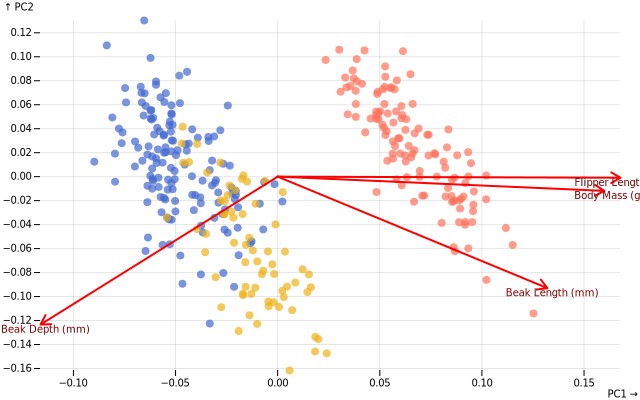

In [7]:
ds.plot.ordiplot(pcaEstimator.model, {
  colorBy: penguinsData.map(d => d.Species),
  showLoadings: true,
    loadingFactor: 0
}).show(Plot);

### Interpretation of the PCA biplot

Scaling 2 is used mostly to interpret the arrows.

- Angles betwee variables are prooortional to their correlation. Flipper lenght and body mass are highly and positivement correlated, and negatively correlated against beal depth.
- The leght of the arrows are almost equal, suggesting that they are well represented in this 2D space.

We would rather interpret the dots in scaling 1, but scaling 2 nevertheless gives an idea of distances between the dots.

- The colored biplot shows that two clusters are clearly defined by species using beak depth, and the left cluster, although having some mixing, is mostly separated along beal lenght.

### Scree plot 

A scree plot shows how the proportion of captured variance declines through the pincipal axes.

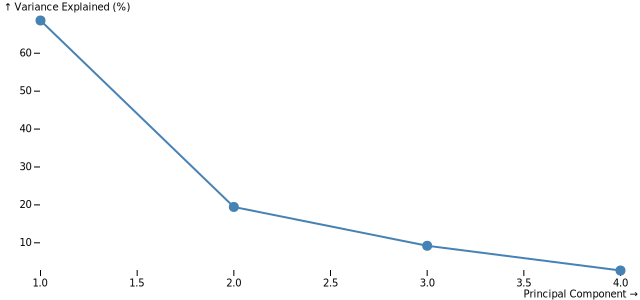

In [8]:
ds.plot
  .plotScree(pcaEstimator.model, { style: "variance" })
  .show(Plot)

The variance declines rapidly. This is coherent with the analysis of the loadings, where we concluded that variables are well represented in the 2D space of the biplot.

## Linear discriminant analysis

If PCA shows *how* individuals vary, LDA asks *which combinations of variables best separate known groups* — here, species. You can think of it as rotating the space again, but now to pull apart the group centroids as much as possible while keeping each group tight. The `.fit()` method of a `LDA` object takes two arguments, the features and the target. In LDA, the target is categorical.

LDA is useful to

- maximize separation between known groups,
- build classifiers,
- identify most discriminating variables, or
- use visualization emphasizing group differences.

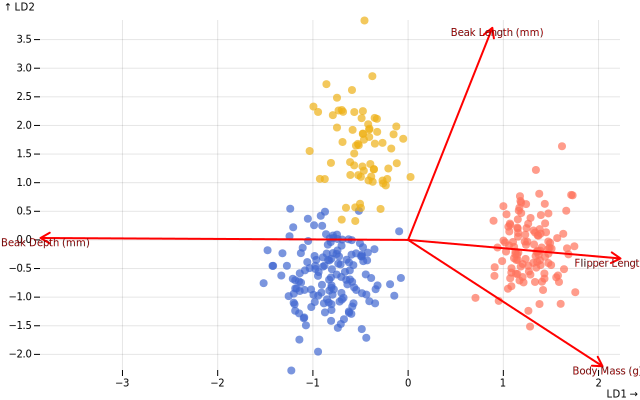

In [9]:
const ldaEstimator = new ds.mva.LDA({
    nComponents: 2,  // max for 3 groups: 3 - 1 = 2
    center: true,
    scale: true,
    scaling: 2
});

ldaEstimator.fit({
    data: penguinsData,
    X: numericColumns,
    y: "Species" // since LDAs are supervised
});

// plot
ds.plot.ordiplot(ldaEstimator.model, {
  colorBy: penguinsData.map(d => d.Species),
  showLoadings: true,
  loadingFactor: 0
}).show(Plot);

## Interpreting the LDA biplot

- In the PCA, species overlap somewhat because it maximizes total variance, not group separation. In the LDA, species form tight, well-separated clusters because it explicitly maximizes group differences.
- LD1 (horizontal axis) captures the most discrimination between species and LD2 (vertical axis) captures the second-most discrimination. LDA finds that these species are quite distinct based on their body measurements.
- The arrows show which measurements contribute most to separating species.

## Redundancy analysis

Take two clouds of points, one for your targets $Y$ (targets you want to explain, like body mass or flipper length), and one for your features $X$ (features that might explain them, like beak size).

RDA asks “if I could tilt and stretch the target data in the same directions as the feature data, what part of the variation in $Y$ would line up?” It does this in two steps.

1. Align the responses with the predictors — that’s just multiple regressions done all at once.
   Every column of $Y$ (each trait) is regressed against by the same predictors in $X$.
   The result, $\hat{Y}$, is the version of $Y$ that can be drawn as a mixture of the predictors. You can think of this as leaning the $Y$ cloud toward $X$.
2. Flatten that explained part with a PCA — rotate the fitted cloud and take its most stretched directions.Those axes show the major gradients that predictors produce in the responses.

That’s why we call this kind of RDA a *constrained PCA*: it’s still PCA geometry, but only inside the slice of space that $X$ can explain. The rest — the residuals ($E=Y-\hat{Y}$) — is what’s left unexplained. You can run a separate PCA on those if you want to see what structure remains after accounting for $X$.

You might find RDA useful to

- understand how predictors explain multiple responses,
- analyze community data (species composition explained by environment),
- test which predictors matter most, or
- visualize multivariate relationships.

In [10]:
// RDA needs categorical variables as dummy (one-hot encoded) variables
const encoder = new ds.core.table.OneHotEncoder();
const encoded = encoder.fitTransform({
    data: penguinsData,
    columns: ["Species", "Sex", "Island"],
    dropFirst: true
});

// Merge encoded species with original data
const penguinsWithOneHot = penguinsData.map((row, i) => ({
    ...row,
    ...encoded[i]
}));

console.table(penguinsWithOneHot.slice(0, 6));

┌───────┬──────────┬─────────────┬──────────────────┬─────────────────┬─────────────────────┬───────────────┬──────────┬───────────────────┬────────────────┬────────────┬───────────────┬──────────────┐
│ (idx) │ Species  │ Island      │ Beak Length (mm) │ Beak Depth (mm) │ Flipper Length (mm) │ Body Mass (g) │ Sex      │ Species_Chinstrap │ Species_Gentoo │ Sex_FEMALE │ Island_Biscoe │ Island_Dream │
├───────┼──────────┼─────────────┼──────────────────┼─────────────────┼─────────────────────┼───────────────┼──────────┼───────────────────┼────────────────┼────────────┼───────────────┼──────────────┤
│     0 │ "Adelie" │ "Torgersen" │ 39.1             │ 18.7            │ 181                 │ 3750          │ "MALE"   │ 0                 │ 0              │ 0          │ 0             │ 0            │
│     1 │ "Adelie" │ "Torgersen" │ 39.5             │ 17.4            │ 186                 │ 3800          │ "FEMALE" │ 0                 │ 0              │ 1          │ 0             │ 0    

In [11]:
const rdaEstimator = new ds.mva.RDA({
    nComponents: 2,
    scale: true,
    scaling: 1  // Distance biplot
});

rdaEstimator.fit({
    data: penguinsWithOneHot,
    // Response: species as dummy variables (we can drop one, it's redundant)
    response: ["Species_Chinstrap", "Species_Gentoo"], 
    // Predictors: the measurements
    predictors: [...numericColumns, "Sex_FEMALE", "Island_Biscoe", "Island_Dream"]
});
undefined;

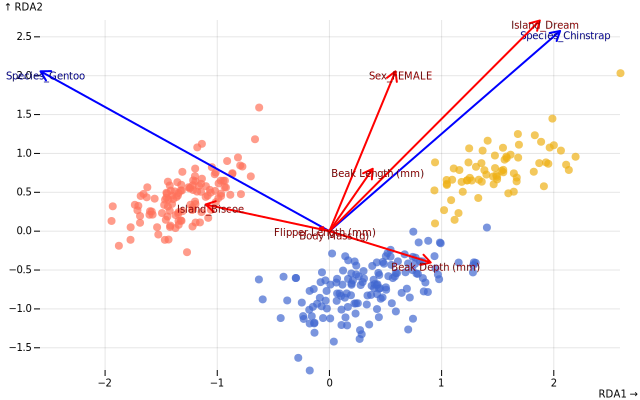

In [12]:
ds.plot.ordiplot(rdaEstimator.model, {
  colorBy: penguinsData.map(d => d.Species),
  showLoadings: true,
  loadingFactor: 0,
  predictorFactor: 0
}).show(Plot);

## Interpreting the RDA Biplot

- There are two types of arrows. Red arrows  design the predictors (the environment) and blue arrows the responses (species encoded variables).
- RDA axes show the variation in species composition that can be explained by the measurements.
- Similar to LDA, species should be well-separated.
- The relationship between measurement arrows and species arrows shows which measurements best distinguish which species. The island well determines the species. Chinstrap penguins seem to tend being females. In terms of physionomy, beak dimensions seem to carry more useful information than flipper length and body mass.